**This is a work in progress. Training set is sampled at 5% and image size is set far smaller than optimal in order to run in a reasonable amount of time. Code to generate appropriate RLE output for submission is not ready yet, I will add it when it is. **

That being said, this competition seems like a great opportunity to learn about segmentation. I wanted to try the fastai dynamic unet here, but the tutorials on segmentation with fastai I could find all relied on the masks existing as seperate image files with names that could be easily inferred from the image files in some way. I could not find a method for generating ImageSegment objects automatically from run-encoded pixels to drop into a databunch, so after some *unknown* amount of effort I made one (I think).

This is the first time I tried customizing fastai code so I'm sure there are both more elegant and efficient ways of doing it, if you know any please don't hesitate to let me know.

In [1]:
#!pip install pytorchcv

In [2]:
import numpy as np
import pandas as pd
import os
import fastai
from fastai.vision import *
from fastai.callbacks import MixedPrecision
path = Path('../input')

In [3]:
'''from pytorchcv.model_provider import get_model as ptcv_get_model
def xcp(f=None):
    n = ptcv_get_model('resnet18_wd4', pretrained=True)
    n.features.final_pool = nn.AvgPool2d(kernel_size=7, stride=1, padding=3)
    n = n.features
    return n'''

"from pytorchcv.model_provider import get_model as ptcv_get_model\ndef xcp(f=None):\n    n = ptcv_get_model('resnet18_wd4', pretrained=True)\n    n.features.final_pool = nn.AvgPool2d(kernel_size=7, stride=1, padding=3)\n    n = n.features\n    return n"

In [4]:
train_df = pd.read_csv(path/"train.csv")

In [5]:
def lb_fnc(j):
    #print(len(j[1]))
    return j[1]
lbf = lambda x: x[1]
codes = list(train_df['ClassId'].values)
train_df['code'] = train_df['ClassId'].apply(lambda x: x.split('_')[0])
trs = train_df.sample(frac=0.01).reset_index(drop=True)
code = list(set(trs['code'].values))

In [6]:
def open_mask_rle(mask_rle:str, shape:Tuple[int, int])->ImageSegment:
    "Return `ImageSegment` object create from run-length encoded string in `mask_lre` with size in `shape`."
    x = FloatTensor(rle_decode(str(mask_rle), shape).astype(np.uint8))
    x = x.view(shape[1], shape[0], -1)
    return ImageSegment(x.permute(2,1,0))

In [7]:
class SegRleItem(ItemBase):
    def __init__(self, image, mask):
        self.image = image
        self.mask = mask
        self.obj,self.data = (image, mask),(image.data,mask.data)
        
    def apply_tfms(self, tfms, *args, **kwargs):
        self.mask = self.mask.apply_tfms(tfms, *args, **kwargs)
        self.image = self.image.apply_tfms(tfms, *args, **kwargs)
        self.data = self.image.data,self.mask.data
        return self
    
    def __repr__(self): return f'{self.__class__.__name__} {self.image.shape, self.mask.shape}'
    
    def to_one(self): return (Image(self.image.data), ImageSegment(self.mask.data))

In [8]:
def open_mask_rle(mask_rle:str, shape:Tuple[int, int])->ImageSegment:
    "Return `ImageSegment` object create from run-length encoded string in `mask_lre` with size in `shape`."
    x = FloatTensor(rle_decode(str(mask_rle), shape).astype(np.uint8))
    x = x.view(shape[1], shape[0], -1)
    return ImageSegment(x.permute(2,1,0))

In [9]:
class SegRleLabel(ItemBase):
    def __init__(self, mask):
        self.mask = mask
        self.obj,self.data = mask,mask.data
        
    def apply_tfms(self, tfms, *args, **kwargs):
        self.mask = self.mask.apply_tfms(tfms, *args, **kwargs)
        self.data = self.mask.data
        return self
    
    def __repr__(self): return f'{self.__class__.__name__} {self.mask.shape}'
    
    def to_one(self): return ImageSegment(self.mask.data)

In [10]:
class SegRleImage(ItemBase):
    def __init__(self, image):
        self.image = image
        self.obj,self.data = image,image.data
        
    def apply_tfms(self, tfms, *args, **kwargs):
        self.image = self.image.apply_tfms(tfms, *args, **kwargs)
        self.data = self.image.data
        return self
    
    def __repr__(self): return f'{self.__class__.__name__} {self.image.shape}'
    
    def to_one(self): return Image(self.image.data)

In [11]:
class ImageList(ItemList):
    "`ItemList` suitable for computer vision."
    _bunch,_square_show,_square_show_res = ImageDataBunch,True,True
    def __init__(self, *args, convert_mode='RGB', after_open:Callable=None, **kwargs):
#        print('ImageList_init')
        super().__init__(*args, **kwargs)

    def open(self, fn):
        "Open image in `fn`, subclass and overwrite for custom behavior."
        return open_image(fn, convert_mode=self.convert_mode, after_open=self.after_open)

    def get(self, i):
        fn = super().get(i)
        mn = fn[1]
        fn = fn[0]
        res = self.open(fn)
        self.sizes[i] = res.size 
        res = SegRleItem(res, mn)
        return res
    
    @classmethod
    def from_folder(cls, path:PathOrStr='.', extensions:Collection[str]=None, **kwargs)->'ItemList':
        "Get the list of files in `path` that have an image suffix. `recurse` determines if we search subfolders."
        extensions = ifnone(extensions, image_extensions)
        return super().from_folder(path=path, extensions=extensions, **kwargs)

    @classmethod
    def from_df(cls, df:DataFrame, path:PathOrStr, cols:IntsOrStrs=0, folder:PathOrStr=None, suffix:str='', **kwargs)->'ItemList':
        "Get the filenames in `cols` of `df` with `folder` in front of them, `suffix` at the end."
        suffix = suffix or ''
        res = super().from_df(df, path=path, cols=cols[0], **kwargs)
        msk = ItemList.from_df(df, path, cols=[1,2,3])
        pref = f'{res.path}{os.path.sep}'
        if folder is not None: pref += f'{folder}{os.path.sep}'
        res.items = np.char.add(np.char.add(pref, res.items.astype(str)), suffix)
        res.items = np.array([(res.items[i], msk[i]) for i in range(len(res.items))])
        return res
    
    def label_from_func(self, func:Callable, label_cls:Callable=None, **kwargs)->'LabelListTpl':
        "Apply `func` to every input to get its label."
        return self._label_from_list([func(o) for o in self.items], label_cls=label_cls, **kwargs)

    @classmethod
    def from_csv(cls, path:PathOrStr, csv_name:str, header:str='infer', **kwargs)->'ItemList':
        "Get the filenames in `path/csv_name` opened with `header`."
        path = Path(path)
        df = pd.read_csv(path/csv_name, header=header)
        return cls.from_df(df, path=path, **kwargs)

    def reconstruct(self, t:Tensor): return Image(t.float().clamp(min=0,max=1))

    def show_xys(self, xs, ys, imgsize:int=4, figsize:Optional[Tuple[int,int]]=None, **kwargs):
        "Show the `xs` (inputs) and `ys` (targets) on a figure of `figsize`."
        rows = int(np.ceil(math.sqrt(len(xs))))
        axs = subplots(rows, rows, imgsize=imgsize, figsize=figsize)
        for x,y,ax in zip(xs, ys, axs.flatten()): x.show(ax=ax, y=y, **kwargs)
        for ax in axs.flatten()[len(xs):]: ax.axis('off')
        plt.tight_layout()

    def show_xyzs(self, xs, ys, zs, imgsize:int=4, figsize:Optional[Tuple[int,int]]=None, **kwargs):
        "Show `xs` (inputs), `ys` (targets) and `zs` (predictions) on a figure of `figsize`."
        if self._square_show_res:
            title = 'Ground truth\nPredictions'
            rows = int(np.ceil(math.sqrt(len(xs))))
            axs = subplots(rows, rows, imgsize=imgsize, figsize=figsize, title=title, weight='bold', size=12)
            for x,y,z,ax in zip(xs,ys,zs,axs.flatten()): x.show(ax=ax, title=f'{str(y)}\n{str(z)}', **kwargs)
            for ax in axs.flatten()[len(xs):]: ax.axis('off')
        else:
            title = 'Ground truth/Predictions'
            axs = subplots(len(xs), 2, imgsize=imgsize, figsize=figsize, title=title, weight='bold', size=14)
            for i,(x,y,z) in enumerate(zip(xs,ys,zs)):
                x.show(ax=axs[i,0], y=y, **kwargs)
                x.show(ax=axs[i,1], y=z, **kwargs)

In [12]:
class SegRleItems(ItemBase):
    def __init__(self, image, mask_arr):
        self.image = image
        self.mask_arr = mask_arr
        self.mask = open_mask_rle(self.mask_arr[0], (self.mask_arr[1], self.mask_arr[2]))
        self.obj,self.data = (self.image, self.mask),(self.image.data,self.mask.data)
        
    def apply_tfms(self, tfms, *args, **kwargs):
        self.mask = self.mask.apply_tfms(tfms, *args, **kwargs)
        self.image = self.image.apply_tfms(tfms, *args, **kwargs)
        self.data = self.image.data,self.mask.data
        return self
    
    def __repr__(self): return f'{self.__class__.__name__} {self.image.shape, self.mask.shape}'
    
    def to_one(self): return (Image(self.image.data), ImageSegment(self.mask.data))

In [13]:
class SegmentationProcessor(PreProcessor):
    "`PreProcessor` that stores the classes for segmentation."
    def __init__(self, ds:ItemList): 
        self.classes = ds.classes
    def process(self, ds:ItemList):  
        ds.classes,ds.c = self.classes,len(self.classes)

class SegmentationLabelList(ItemList):
    "`ItemList` for segmentation masks."
    _processor=SegmentationProcessor
    def __init__(self, items:Iterator, classes:Collection=None, **kwargs):
        super().__init__(items, **kwargs)
        self.copy_new.append('classes')
        self.classes,self.loss_func = classes,CrossEntropyFlat(axis=1)

    def get(self, i):
        fn = super().get(i)
        res = self.open(fn)
        return res
        
    def open(self, fn): 
        fn = open_mask_rle(fn[0], (fn[1], fn[2]))
        fn = SegRleLabel(fn)
        return fn
    def analyze_pred(self, pred, thresh:float=0.5): return pred.argmax(dim=0)[None]
    def reconstruct(self, t:Tensor): return SegRleLabel(t)

class SegmentationItemList(ImageList):
    "`ItemList` suitable for segmentation tasks."
    _label_cls,_square_show_res = SegmentationLabelList,False

In [14]:
class SegRleList(SegmentationItemList):
    "`ItemList` suitable for computer vision."
    _bunch,_square_show,_square_show_res = ImageDataBunch,True,True
    def __init__(self, *args, convert_mode='RGB', after_open:Callable=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.convert_mode,self.after_open = convert_mode,after_open
        self.copy_new.append('convert_mode')
        self.c,self.sizes = 3,{}
        
    def create(cls, labels:Collection=None, classes:dict=None)->'SegRleList':
        "Create an ImageLabeled object with `labels`."
        return cls(labels=labels, classes=classes)
    
    def get(self, i):
        res = super().get(i)
        res = SegRleImage(Image(res.data[0])) 
        return res

    def reconstruct(self, t:Tensor): 
        return SegRleImage(t)
    
    def show_xys(self, xs, ys, figsize:Tuple[int,int]=(12,6), **kwargs):
        "Show the `xs` and `ys` on a figure of `figsize`. `kwargs` are passed to the show method."
        rows = int(math.sqrt(len(xs)))
        fig, axs = plt.subplots(rows,rows,figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            ym = ys[i].to_one()
            xs[i].to_one().show(ax=ax, y=ym, **kwargs, alpha=0.7)
        plt.tight_layout()

    def show_xyzs(self, xs, ys, zs, figsize:Tuple[int,int]=None, **kwargs):
        """Show `xs` (inputs), `ys` (targets) and `zs` (predictions) on a figure of `figsize`.
        `kwargs` are passed to the show method."""
        figsize = ifnone(figsize, (12,3*len(xs)))
        fig,axs = plt.subplots(len(xs), 2, figsize=figsize)
        fig.suptitle('Ground truth / Predictions', weight='bold', size=14)
        for i,(x,z) in enumerate(zip(xs,zs)):
            x.to_one().show(ax=axs[i,0], **kwargs)
            z.to_one().show(ax=axs[i,1], **kwargs)


In [15]:
db = (SegRleList.from_df(trs, path, cols=[0,1,2,3], folder='train')
     .split_by_rand_pct()
     .label_from_func(lbf, classes=code) 
     .transform(get_transforms(), tfm_y=True, size=224)
     .databunch(bs=16, num_workers=0)
     .normalize(imagenet_stats)
     )

In [16]:
len(db.train_ds)

2668

In [17]:
db.valid_ds

LabelList (666 items)
x: SegRleList
SegRleImage torch.Size([3, 224, 224]),SegRleImage torch.Size([3, 224, 224]),SegRleImage torch.Size([3, 224, 224]),SegRleImage torch.Size([3, 224, 224]),SegRleImage torch.Size([3, 224, 224])
y: SegmentationLabelList
SegRleLabel torch.Size([1, 224, 224]),SegRleLabel torch.Size([1, 224, 224]),SegRleLabel torch.Size([1, 224, 224]),SegRleLabel torch.Size([1, 224, 224]),SegRleLabel torch.Size([1, 224, 224])
Path: ../input

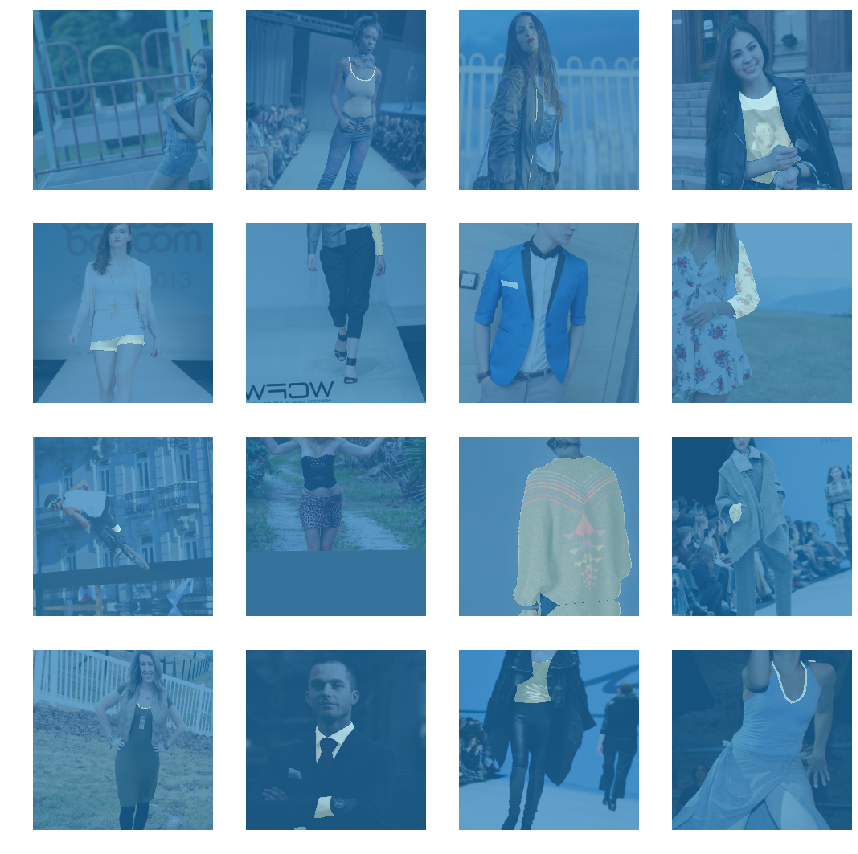

In [18]:
db.show_batch(rows=4, figsize=(12,12))

In [19]:
acc_05 = partial(accuracy_thresh, thresh=0.5)

In [23]:
learn = unet_learner(db, 
                     models.resnet18, 
                     metrics=[acc_05], 
                     #loss_func=nn.BCEWithLogitsLoss(),
                     wd=1e-2,
                     model_dir="/kaggle/working/models")

In [24]:
#learn = learn.to_fp16()
#learn.lr_find() 
#learn.recorder.plot() 

In [ ]:
lr = 1e-3 
learn.fit_one_cycle(1, slice(lr), pct_start=0.9, callbacks=[MixedPrecision(learn)])

epoch,train_loss,valid_loss,accuracy_thresh,time


In [ ]:
pr,yt = learn.get_preds()